# LSTM
An introduction to LSTM Forecasting in scalecast.

- See the model [documentation](https://scalecast.readthedocs.io/en/latest/Forecaster/_forecast.html#module-src.scalecast.Forecaster.Forecaster._forecast_lstm).
- [Data](https://www.kaggle.com/datasets/rakannimer/air-passengers).
- [Blog post](https://towardsdatascience.com/exploring-the-lstm-neural-network-model-for-time-series-8b7685aa8cf).
- [RNN Example Notebook](https://scalecast-examples.readthedocs.io/en/latest/rnn/rnn.html).
- Required library: `pip install tensorflow`

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scalecast.Forecaster import Forecaster

In [2]:
data = pd.read_csv('AirPassengers.csv',parse_dates=['Month'])

## EDA

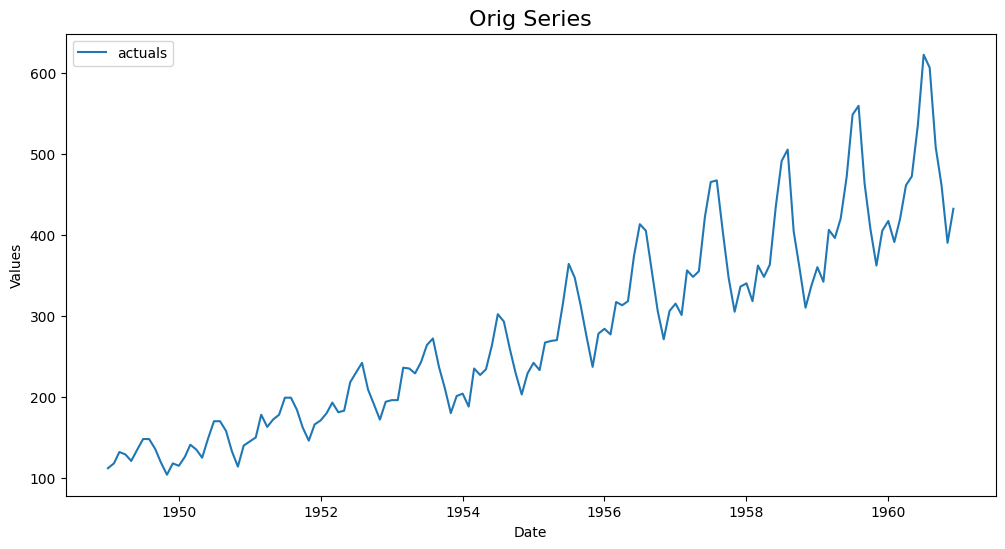

In [3]:
f = Forecaster(
    y=data['#Passengers'],
    current_dates=data['Month'],
    test_length = 12,
    future_dates = 12,
    cis = False,
)
f.plot()
plt.title('Orig Series',size=16)
plt.show()

In [4]:
f

Forecaster(
    DateStartActuals=1949-01-01T00:00:00.000000000
    DateEndActuals=1960-12-01T00:00:00.000000000
    Freq=MS
    N_actuals=144
    ForecastLength=12
    Xvars=[]
    Differenced=0
    TestLength=12
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    BootstrapSamples=100
    CurrentEstimator=None
    GridsFile=Grids
)

C:\Users\michaelkeith\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


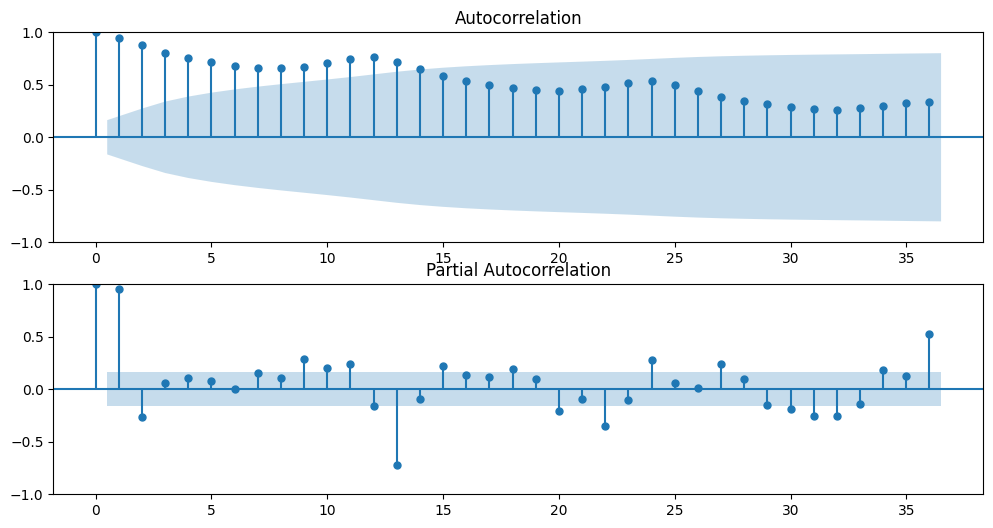

In [5]:
figs, axs = plt.subplots(2, 1,figsize=(12,6))
f.plot_acf(ax=axs[0],lags=36)
f.plot_pacf(ax=axs[1],lags=36)
plt.show()

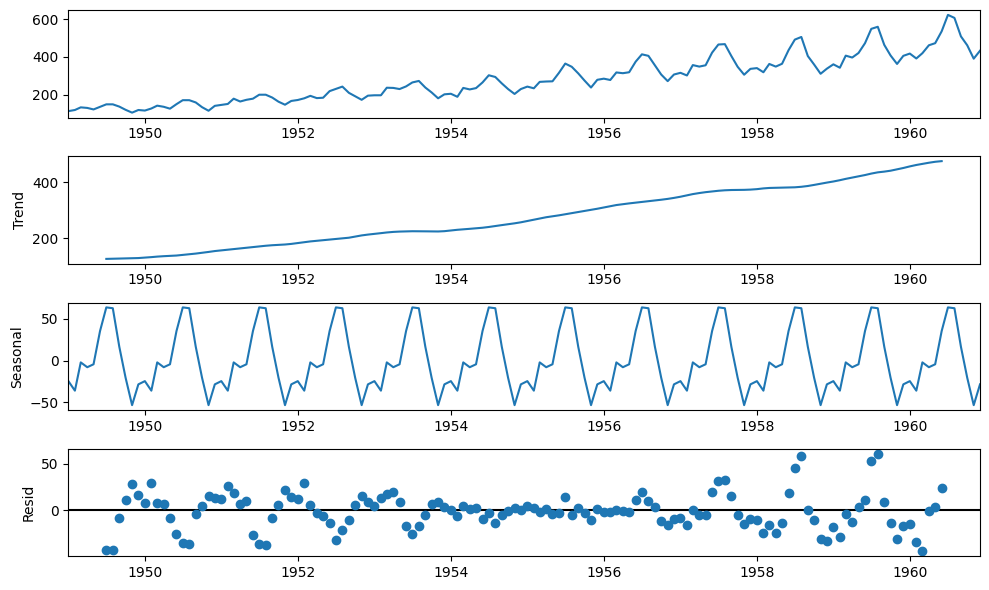

In [6]:
plt.rc("figure",figsize=(10,6))
f.seasonal_decompose().plot()
plt.show()

The below shows the results of the ADF test indicate the series is not stationary.

In [7]:
critical_pval = 0.05
print('-'*100)
print('Augmented Dickey-Fuller results:')
stat, pval, _, _, _, _ = f.adf_test(full_res=True)
print('the test-stat value is: {:.2f}'.format(stat))
print('the p-value is {:.4f}'.format(pval))
print('the series is {}'.format('stationary' if pval < critical_pval else 'not stationary'))
print('-'*100)

----------------------------------------------------------------------------------------------------
Augmented Dickey-Fuller results:
the test-stat value is: 0.82
the p-value is 0.9919
the series is not stationary
----------------------------------------------------------------------------------------------------


## LSTM Model

### Attempt 1
- Default parameters.

In [8]:
f.set_estimator('lstm')
f.manual_forecast(call_me='lstm_default')

5/5 [==============================] - 1s 2ms/step - loss: 0.3505


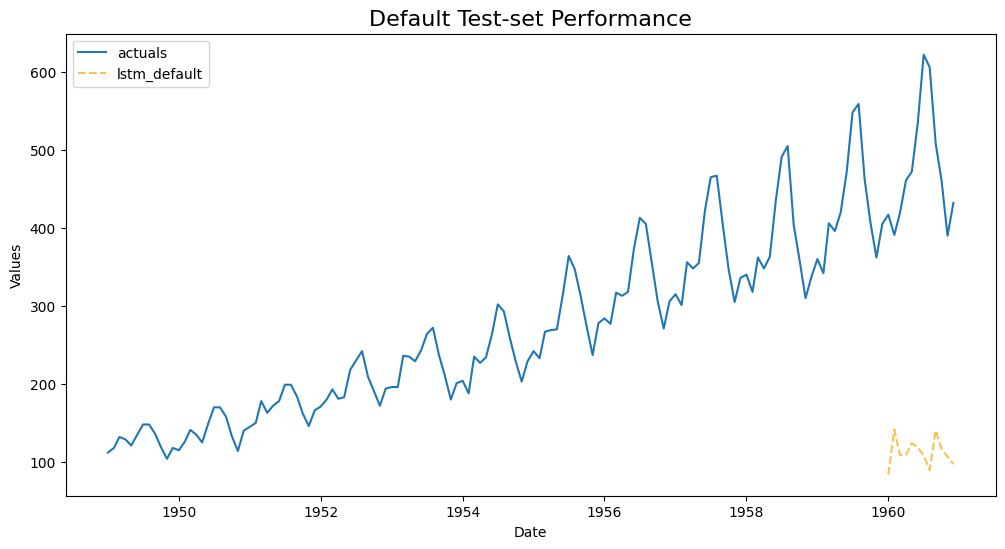

In [9]:
f.plot_test_set()
plt.title('Default Test-set Performance',size=16)
plt.show()

### Attempt 2
- Add more lags (2 years).

In [10]:
f.manual_forecast(call_me='lstm_24lags',lags=24)

4/4 [==============================] - 1s 9ms/step - loss: 0.3861


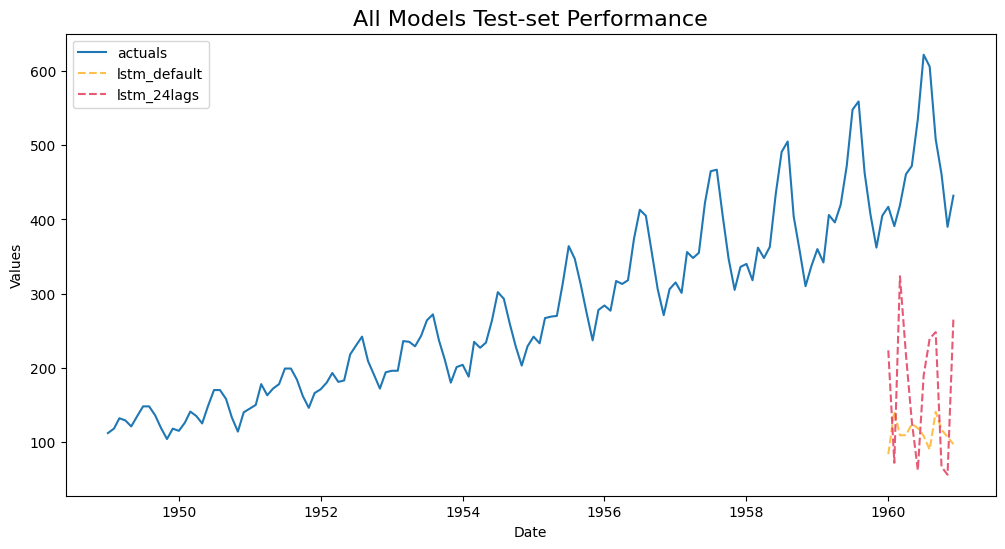

In [11]:
f.plot_test_set()
plt.title('All Models Test-set Performance',size=16)
plt.show()

### Attempt 3
- Add more epochs (5).

In [12]:
f.manual_forecast(call_me='lstm_24lags_5epochs',lags=24,epochs=5,validation_split=.2,shuffle=True)

Epoch 1/5
3/3 [==============================] - 2s 212ms/step - loss: 0.4887 - val_loss: 0.2016
Epoch 2/5
3/3 [==============================] - 0s 17ms/step - loss: 0.4803 - val_loss: 0.1959
Epoch 3/5
3/3 [==============================] - 0s 21ms/step - loss: 0.4718 - val_loss: 0.1903
Epoch 4/5
3/3 [==============================] - 0s 17ms/step - loss: 0.4637 - val_loss: 0.1848
Epoch 5/5
3/3 [==============================] - 0s 20ms/step - loss: 0.4556 - val_loss: 0.1794
Epoch 1/5
3/3 [==============================] - 2s 176ms/step - loss: 0.4441 - val_loss: 0.1710
Epoch 2/5
3/3 [==============================] - 0s 24ms/step - loss: 0.4360 - val_loss: 0.1649
Epoch 3/5
3/3 [==============================] - 0s 24ms/step - loss: 0.4279 - val_loss: 0.1588
Epoch 4/5
3/3 [==============================] - 0s 21ms/step - loss: 0.4194 - val_loss: 0.1526
Epoch 5/5
3/3 [==============================] - 0s 20ms/step - loss: 0.4108 - val_loss: 0.1463


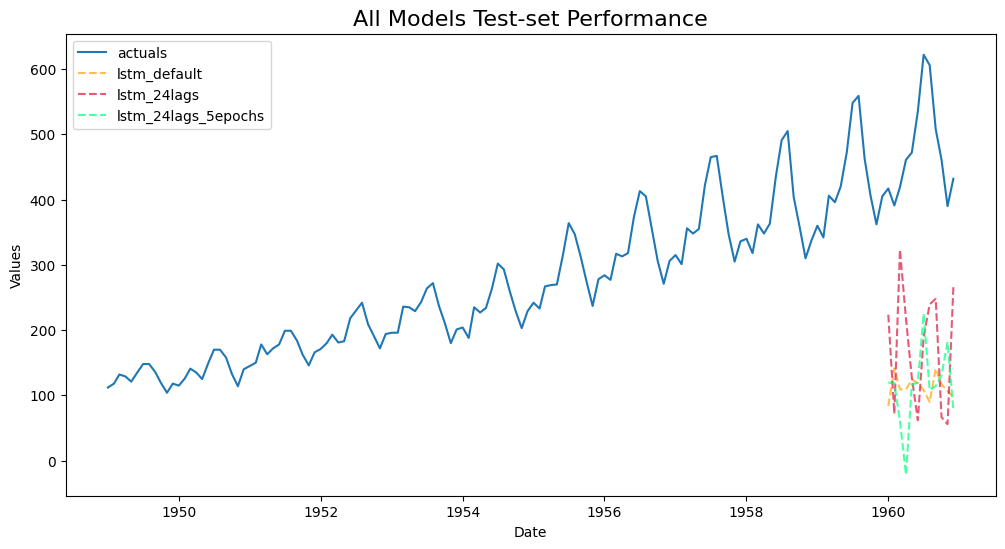

In [13]:
f.plot_test_set()
plt.title('All Models Test-set Performance',size=16)
plt.show()

### Attempt 4
- Add layers and early stoping.

In [14]:
from tensorflow.keras.callbacks import EarlyStopping
f.manual_forecast(
    call_me='lstm_24lags_earlystop_3layers',
    lags=24,
    epochs=25,
    validation_split=.2,
    shuffle=True,
    callbacks=EarlyStopping(
      monitor='val_loss',
      patience=5
    ),
    lstm_layer_sizes=(16,16,16),
    dropout=(0,0,0)
)

Epoch 1/25
3/3 [==============================] - 5s 429ms/step - loss: 0.4657 - val_loss: 0.1889
Epoch 2/25
3/3 [==============================] - 0s 40ms/step - loss: 0.4502 - val_loss: 0.1772
Epoch 3/25
3/3 [==============================] - 0s 36ms/step - loss: 0.4312 - val_loss: 0.1625
Epoch 4/25
3/3 [==============================] - 0s 36ms/step - loss: 0.4070 - val_loss: 0.1435
Epoch 5/25
3/3 [==============================] - 0s 42ms/step - loss: 0.3745 - val_loss: 0.1195
Epoch 6/25
3/3 [==============================] - 0s 36ms/step - loss: 0.3319 - val_loss: 0.1003
Epoch 7/25
3/3 [==============================] - 0s 35ms/step - loss: 0.2798 - val_loss: 0.1017
Epoch 8/25
3/3 [==============================] - 0s 42ms/step - loss: 0.2390 - val_loss: 0.1377
Epoch 9/25
3/3 [==============================] - 0s 34ms/step - loss: 0.2171 - val_loss: 0.1747
Epoch 10/25
3/3 [==============================] - 0s 35ms/step - loss: 0.2088 - val_loss: 0.1792
Epoch 11/25
3/3 [===========

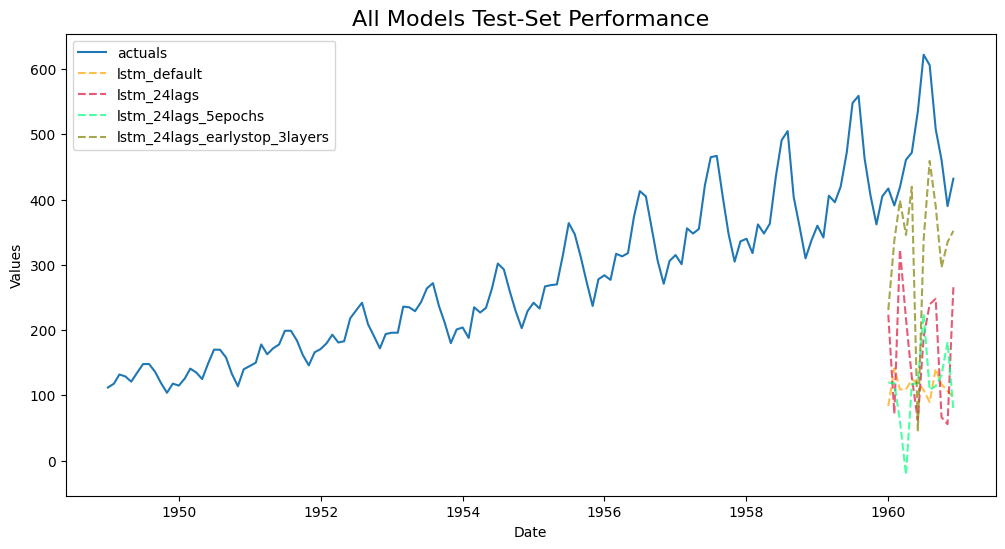

In [15]:
f.plot_test_set()
plt.title('All Models Test-Set Performance',size=16)
plt.show()

### Attempt 5
- Add more lags (3 years).

Epoch 1/15
3/3 [==============================] - 6s 773ms/step - loss: 0.4871 - val_loss: 0.1988
Epoch 2/15
3/3 [==============================] - 0s 71ms/step - loss: 0.3676 - val_loss: 0.1011
Epoch 3/15
3/3 [==============================] - 0s 71ms/step - loss: 0.2076 - val_loss: 0.1164
Epoch 4/15
3/3 [==============================] - 0s 70ms/step - loss: 0.1386 - val_loss: 0.0582
Epoch 5/15
3/3 [==============================] - 0s 73ms/step - loss: 0.1285 - val_loss: 0.0649
Epoch 6/15
3/3 [==============================] - 0s 77ms/step - loss: 0.1125 - val_loss: 0.0824
Epoch 7/15
3/3 [==============================] - 0s 68ms/step - loss: 0.1136 - val_loss: 0.0607
Epoch 8/15
3/3 [==============================] - 0s 72ms/step - loss: 0.1156 - val_loss: 0.0539
Epoch 9/15
3/3 [==============================] - 0s 67ms/step - loss: 0.1006 - val_loss: 0.0528
Epoch 10/15
3/3 [==============================] - 0s 66ms/step - loss: 0.0934 - val_loss: 0.0528
Epoch 11/15
3/3 [===========

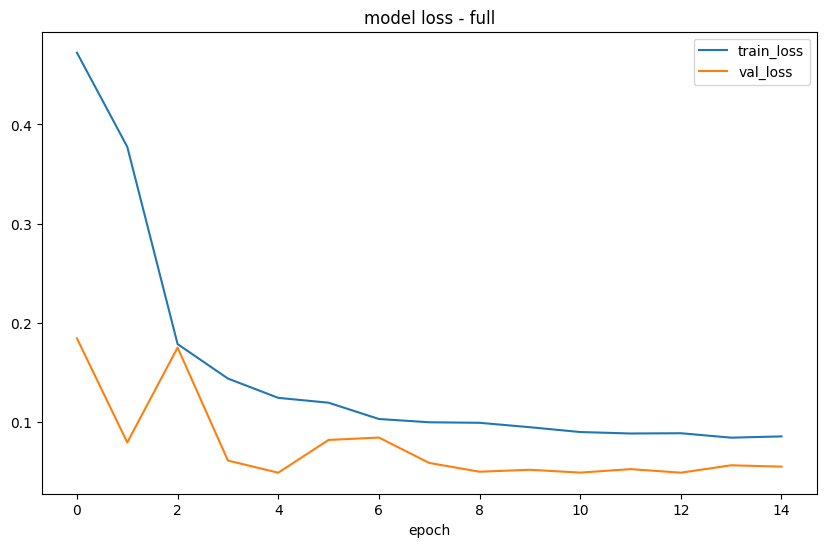

In [16]:
f.manual_forecast(
    call_me='lstm_24lags_4layers_15epochs',
    lags=36,
    batch_size=32,
    epochs=15,
    validation_split=.2,
    shuffle=True,
    activation='tanh',
    optimizer='Adam',
    learning_rate=0.001,
    lstm_layer_sizes=(72,)*4,
    dropout=(0,)*4,
    plot_loss=True
)

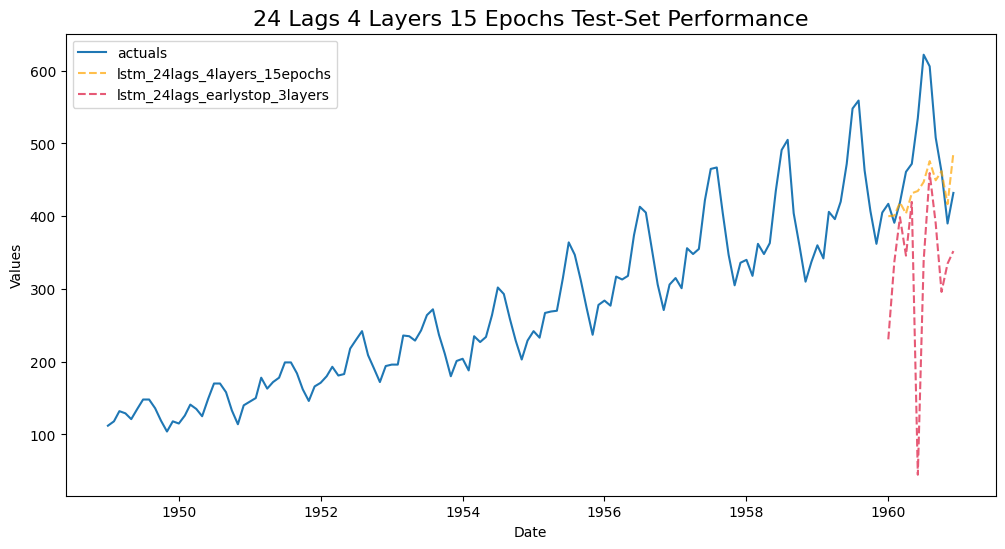

In [17]:
f.plot_test_set(order_by='LevelTestSetMAPE',models='top_2')
plt.title('24 Lags 4 Layers 15 Epochs Test-Set Performance',size=16)
plt.show()

The last model run looks in the same ballpark as the actual series' trend, but still not great. Let's take things to the next level with this model by adding many more layers and training epochs.

### Attempt 6
- add more layers (15) and epochs (300)

Epoch 1/300
5/5 [==============================] - 27s 2s/step - loss: 0.4635 - val_loss: 0.2024
Epoch 2/300
5/5 [==============================] - 2s 352ms/step - loss: 0.2719 - val_loss: 0.1083
Epoch 3/300
5/5 [==============================] - 2s 355ms/step - loss: 0.1919 - val_loss: 0.2639
Epoch 4/300
5/5 [==============================] - 2s 362ms/step - loss: 0.1484 - val_loss: 0.1918
Epoch 5/300
5/5 [==============================] - 2s 359ms/step - loss: 0.1496 - val_loss: 0.2022
Epoch 6/300
5/5 [==============================] - 2s 331ms/step - loss: 0.1392 - val_loss: 0.2598
Epoch 7/300
5/5 [==============================] - 2s 370ms/step - loss: 0.1411 - val_loss: 0.2068
Epoch 8/300
5/5 [==============================] - 2s 350ms/step - loss: 0.1387 - val_loss: 0.2316
Epoch 9/300
5/5 [==============================] - 2s 338ms/step - loss: 0.1401 - val_loss: 0.2368
Epoch 10/300
5/5 [==============================] - 2s 329ms/step - loss: 0.1347 - val_loss: 0.1499
Epoch 11/30

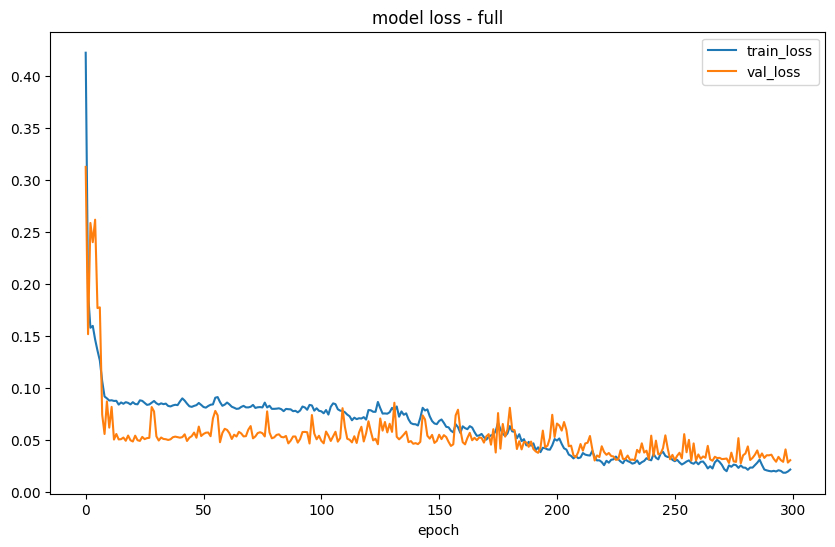

In [18]:
f.manual_forecast(
    call_me='lstm_best',
    lags=36,
    batch_size=16,
    epochs=300,
    validation_split=.2,
    shuffle=True,
    activation='tanh',
    optimizer='Adam',
    learning_rate=0.001,
    lstm_layer_sizes=(100,)*15,
    dropout=(0,)*15,
    plot_loss=True,
)

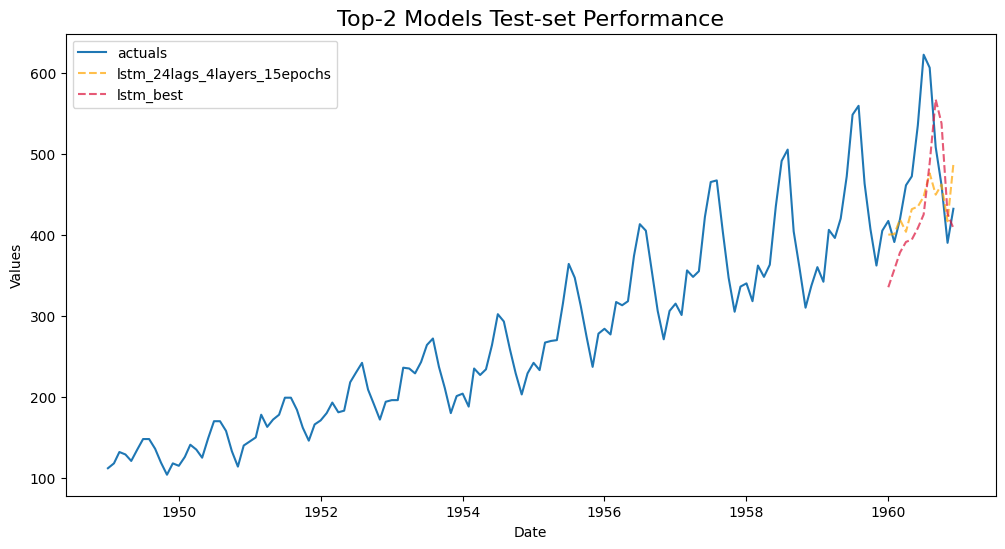

In [19]:
f.plot_test_set(order_by='LevelTestSetMAPE',models='top_2')
plt.title('Top-2 Models Test-set Performance',size=16)
plt.show()

Finally, an LSTM model that looks somewhat believable, but it took a lot of work and took a long time to evaluate. Let's see if we can outpace this performance with a simple linear regression model.

## Prepare Forecast for MLR
- Test length already set
- Forecast horizon already set
- Add lags (24) - for MLR, these are added as regressors, not specified when calling the model (unlike LSTM)
- Add seasonal regressors (month, quarter - using dummy vars)
- Add year variable
- Add time trend
- Difference data since it is not stationary

In [30]:
from scalecast.SeriesTransformer import SeriesTransformer

transformer = SeriesTransformer(f,deepcopy=False)
f = transformer.DiffTransform()

f.add_ar_terms(24)
f.add_seasonal_regressors('month','quarter',dummy=True)
f.add_seasonal_regressors('year')
f.add_time_trend()

## MLR Modeling

In [31]:
f.set_estimator('mlr')
f.manual_forecast()

In [32]:
f = transformer.DiffRevert(
    exclude_models = [m for m in f.history if m != 'mlr']
) # exclude all lstm models already called from the revert

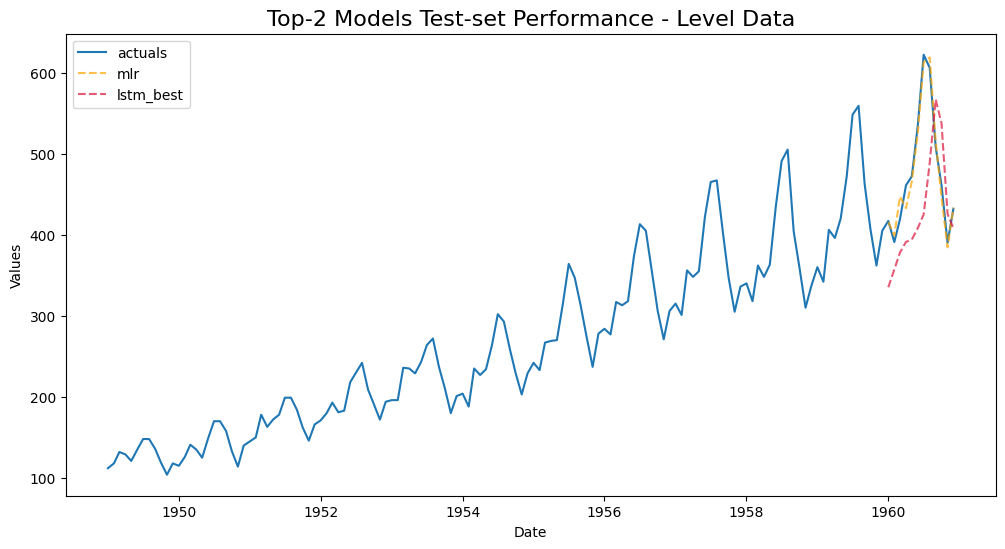

In [36]:
f.plot_test_set(order_by='TestSetMAPE',models=['lstm_best','mlr'])
plt.title('Top-2 Models Test-set Performance - Level Data',size=16)
plt.show()

It is obvious that with much less work, we find a significantly better model. LSTM is not always suited for small datasets.

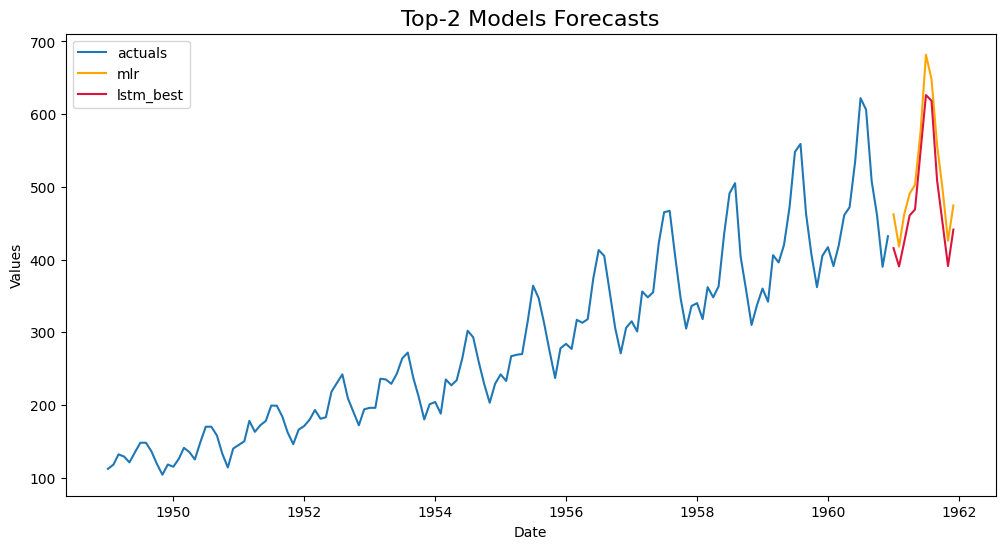

In [35]:
f.plot(order_by='TestSetMAPE',models=['lstm_best','mlr'])
plt.title('Top-2 Models Forecasts',size=16)
plt.show()

## Benchmarking

In [37]:
f.export('model_summaries',determine_best_by='TestSetMAPE')[
    ['ModelNickname','TestSetMAPE','TestSetRMSE','TestSetR2','best_model']
]

,ModelNickname,TestSetMAPE,TestSetRMSE,TestSetR2,best_model
0,mlr,0.023420,13.932124,0.964960,True
1,lstm_24lags_4layers_15epochs,0.106074,76.448605,-0.055044,False
2,lstm_best,0.156137,91.456691,-0.509950,False
3,lstm_24lags_earlystop_3layers,0.293719,192.958114,-5.721368,False
4,lstm_24lags,0.629946,320.660515,-17.561907,False
5,lstm_default,0.758766,372.380922,-24.032629,False
6,lstm_24lags_5epochs,0.762139,372.033358,-23.985922,False


## Export Results

### Export forecasts

In [38]:
results = f.export(['lvl_fcsts','lvl_test_set_predictions'],models=['mlr','lstm_best'])
results['lvl_fcsts']

,DATE,mlr,lstm_best
0,1961-01-01,462.246319,415.664827
1,1961-02-01,417.723587,390.457290
2,1961-03-01,461.401526,423.225702
3,1961-04-01,490.464952,460.689152
4,1961-05-01,502.862341,468.800748
5,1961-06-01,576.122326,549.353079
6,1961-07-01,681.663152,626.189951
7,1961-08-01,648.076008,618.365556
8,1961-09-01,557.543683,509.099653
9,1961-10-01,498.170886,451.263476


### Export test-set preds

In [39]:
results['lvl_test_set_predictions']

,DATE,actual,mlr,lstm_best
132,1960-01-01,417.0,415.601711,335.231538
133,1960-02-01,391.0,398.878614,357.154868
134,1960-03-01,419.0,447.300584,378.029843
135,1960-04-01,461.0,432.734374,391.133712
136,1960-05-01,472.0,465.618319,393.996484
137,1960-06-01,535.0,526.516348,408.208210
138,1960-07-01,622.0,612.720998,424.941917
139,1960-08-01,606.0,618.726194,488.303397
140,1960-09-01,508.0,514.480722,566.834567
141,1960-10-01,461.0,445.859651,537.308438


### Export Feature Info
- For MLR only

In [40]:
f.save_feature_importance()
f.export_feature_importance('mlr')

,weight,std
feature,,
AR1,0.078990,0.043293
AR11,0.068242,0.021084
AR10,0.062860,0.006130
AR22,0.036079,0.014061
AR21,0.024636,0.016540
year,0.018015,0.003023
AR13,0.017670,0.020692
t,0.013183,0.000919
month_8,0.012445,0.003274
